In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
#from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import time

x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = to_categorical(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(y_train))
print(np.shape(y_val))

(59500, 784)
(10500, 784)
(59500, 10)
(10500, 10)


In [ ]:
# Using the dataset from keras repository
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_val = x_val.astype('float32') / 255
y_val = to_categorical(y_val)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#import cupy as cp

class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        #Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1-epsln )
        if derivative:
           return (y_pred - y_true)/((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):

        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        #print('Input Shape first layer', np.shape(params['W1']),np.shape(params['A0']))
        params['Z1'] = np.dot(params["W1"], params['A0'])
        #print('Shape first layer', params['Z1'])
        params['A1'] = self.sigmoid(params['Z1'])
        #print('Shape first layer Activation', params['A1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        #print('Shape second layer', np.shape(params['Z2']))
        params['A2'] = self.sigmoid(params['Z2'])
        #print('Shape second layer activation', np.shape(params['A2']))

        # hidden layer 2 to hidden layer 3
        params['Z3'] = np.dot(params["W3"], params['A2'])
        # *** Use SOFTMAX for the final output (10 classes) ***
        params['A3'] = self.softmax(params['Z3']) # A3 is the final prediction, A7 is no longer used
        return params['A3']
        #print('Shape second layer activation', np.shape(params['A3']))

        # hidden layer 3 to hidden layer 4
        params['Z4'] = np.dot(params["W4"], params['A3'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A4'] = self.sigmoid(params['Z4'])
        #print('Shape second layer activation', np.shape(params['A3']))

        # hidden layer 4 to hidden layer 5
        params['Z5'] = np.dot(params["W5"], params['A4'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A5'] = self.sigmoid(params['Z5'])
        #print('Shape second layer activation', np.shape(params['A3']))

        # hidden layer 5 to hidden layer 6
        params['Z6'] = np.dot(params["W6"], params['A5'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A6'] = self.sigmoid(params['Z6'])
        #print('Shape second layer activation', np.shape(params['A3']))

        # hidden layer 6 to hidden layer 7
        params['Z7'] = np.dot(params["W7"], params['A6'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A7'] = self.softmax(params['Z7'])
        #print('Shape second layer activation', np.shape(params['A3']))

        return params['A7']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        #print("Error shape", np.shape(error))
        change_w['W3'] = np.outer(error, params['A2'])
        #print("Change shape", np.shape(change_w['W3']))

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        #print("Error shape", np.shape(error))
        change_w['W2'] = np.outer(error, params['A1'])
        #print("Change shape", np.shape(change_w['W2']))

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        #print("Error shape", np.shape(error))

        change_w['W1'] = np.outer(error, params['A0'])
        #print("Change shape", np.shape(change_w['W1']))

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value



    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x,)
            _loss = self.binary_cross_entrophy(y, output, derivative=False)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions),_loss)



    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            count=0
            for x,y in zip(x_train, y_train):
                count+=1
                output = self.forward_pass(x)
          #      print("output shape", np.shape(output))
          #      print("-------------------------------",count)
                changes_to_w = self.backward_pass(y, output)
          #      print("-------------------------------Backprop")
                self.update_network_parameters(changes_to_w)

            #Accuracy calculation
            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            #Print the values
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, train_accuracy * 100 ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, val_accuracy * 100 ))

            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, train_loss ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, val_loss ))
            print("-------------------------------------------------------------")

            #Append the values
            self.tls.append(np.mean(train_loss))
            self.tacc.append(train_accuracy*100)
            self.vls.append(np.mean(val_loss))
            self.vacc.append(val_accuracy*100)

        #np.save('final_weights',self.params)
        # Plotting figures
        plt.figure(1)
        plt.plot(self.tls,'r',label='training_loss')
        plt.plot(self.vls,'g',label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("loss plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc),'g',label='training_accuracy')
        plt.plot(np.array(self.vacc),'r',label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy plot")
        plt.legend()
        np.save('Data',self)

Epoch: 1, Time Spent: 34.47s, Accuracy: 94.10%
Epoch: 1, Time Spent: 34.47s, Accuracy: 93.93%
Epoch: 1, Time Spent: 34.47s, loss: 0.01
Epoch: 1, Time Spent: 34.47s, loss: 0.00
-------------------------------------------------------------
Epoch: 2, Time Spent: 69.88s, Accuracy: 96.55%
Epoch: 2, Time Spent: 69.88s, Accuracy: 95.97%
Epoch: 2, Time Spent: 69.88s, loss: 0.00
Epoch: 2, Time Spent: 69.88s, loss: 0.00
-------------------------------------------------------------
Epoch: 3, Time Spent: 105.63s, Accuracy: 97.36%
Epoch: 3, Time Spent: 105.63s, Accuracy: 96.70%
Epoch: 3, Time Spent: 105.63s, loss: 0.00
Epoch: 3, Time Spent: 105.63s, loss: 0.00
-------------------------------------------------------------
Epoch: 4, Time Spent: 141.66s, Accuracy: 97.66%
Epoch: 4, Time Spent: 141.66s, Accuracy: 96.85%
Epoch: 4, Time Spent: 141.66s, loss: 0.00
Epoch: 4, Time Spent: 141.66s, loss: 0.00
-------------------------------------------------------------
Epoch: 5, Time Spent: 177.07s, Accuracy:

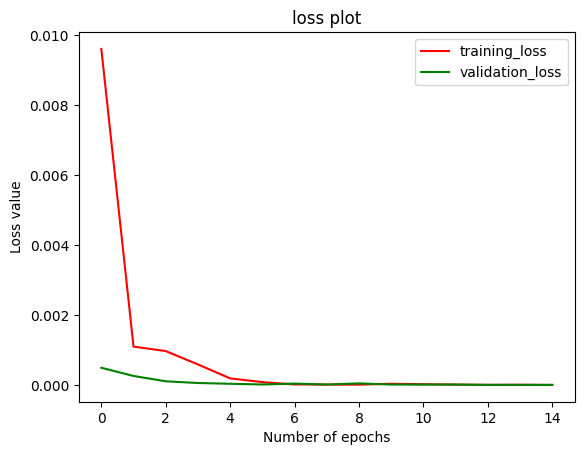

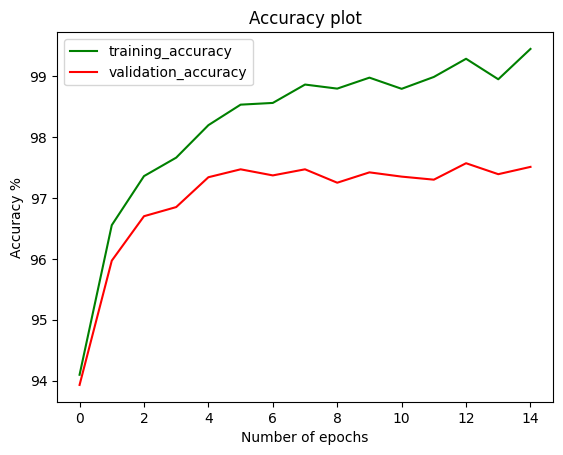

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=15, l_rate=1.0)
dnn.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

In [ ]:
#Reason
1.Overfitting: The primary reason is that the model is learning specific details of the training data too well, leading to a near-perfect fit (training accuracy close to 100%).
 However, these highly specific patterns causing the validation accuracy to stall or even decrease slightly after a certain point (around epoch 5-6).
2.High Model Capacity: A Deep Neural Network with multiple layers (like [784, 128, 64, 10]$) and many parameters has a high capacity (or complexity).
 This allows it to easily memorize the training examples
3.Sufficient Training Epochs: The model was trained for 15 epochs.
 As visible in the plot, the training accuracy continues to improve right up to epoch 14, indicating the model is still finding ways to fit the training set better.
4.High Learning Rate (l_rate=1.0): A learning rate of 1.0 is generally considered very high.
 this aggressive rate allows the model's weights to update significantly in each step,minimizing the loss on the training set.

Epoch: 1, Time Spent: 42.68s, Accuracy: 92.53%
Epoch: 1, Time Spent: 42.68s, Accuracy: 92.71%
Epoch: 1, Time Spent: 42.68s, loss: 0.01
Epoch: 1, Time Spent: 42.68s, loss: 0.00
-------------------------------------------------------------
Epoch: 2, Time Spent: 82.80s, Accuracy: 94.57%
Epoch: 2, Time Spent: 82.80s, Accuracy: 94.47%
Epoch: 2, Time Spent: 82.80s, loss: 0.00
Epoch: 2, Time Spent: 82.80s, loss: 0.00
-------------------------------------------------------------
Epoch: 3, Time Spent: 122.59s, Accuracy: 96.09%
Epoch: 3, Time Spent: 122.59s, Accuracy: 95.63%
Epoch: 3, Time Spent: 122.59s, loss: 0.00
Epoch: 3, Time Spent: 122.59s, loss: 0.00
-------------------------------------------------------------
Epoch: 4, Time Spent: 162.46s, Accuracy: 96.69%
Epoch: 4, Time Spent: 162.46s, Accuracy: 95.96%
Epoch: 4, Time Spent: 162.46s, loss: 0.00
Epoch: 4, Time Spent: 162.46s, loss: 0.00
-------------------------------------------------------------
Epoch: 5, Time Spent: 204.09s, Accuracy:

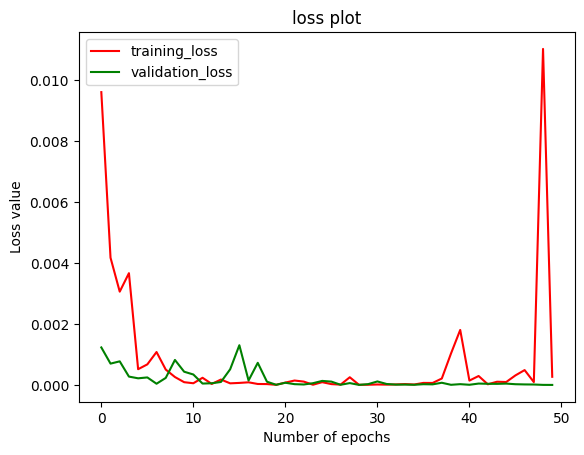

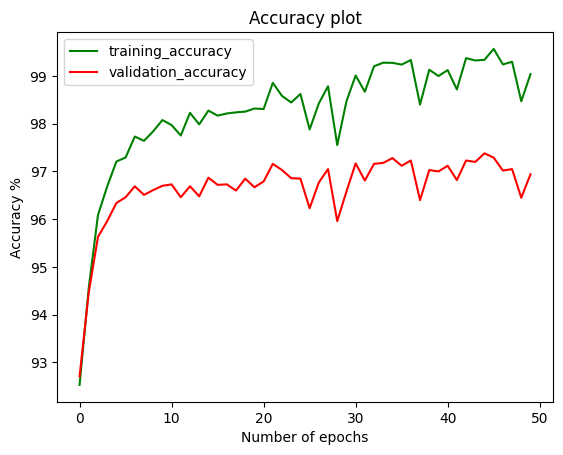

In [ ]:
dnn2 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=50, l_rate=0.5)
dnn2.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

In [ ]:
#Reason
1. Presence of Overfitting (Training and Validation): The persistent gap between the training accuracy (reaching approx 99.2%) and the validation accuracy (peaking at approx 97.4%) is a clear sign of overfitting.
  This suggests that the model size (128 and 64 neurons in the hidden layers) might be too large, or there's a lack of regularization
2.Sufficient Epochs (epochs=50): Training for 50 epochs allowed the model to converge to a reasonably high performance level.
3.High Learning Rate (l_rate=0.5): The large learning rate is the most probable cause for the high fluctuation ("spikiness") observed in both the training and validation accuracy curves.
  This prevents the optimization algorithm (like Gradient Descent) from settling smoothly into a good minimum of the loss function.

Epoch: 1, Time Spent: 35.15s, Accuracy: 58.07%
Epoch: 1, Time Spent: 35.15s, Accuracy: 58.05%
Epoch: 1, Time Spent: 35.15s, loss: 0.35
Epoch: 1, Time Spent: 35.15s, loss: 0.18
-------------------------------------------------------------
Epoch: 2, Time Spent: 70.51s, Accuracy: 62.32%
Epoch: 2, Time Spent: 70.51s, Accuracy: 62.08%
Epoch: 2, Time Spent: 70.51s, loss: 0.33
Epoch: 2, Time Spent: 70.51s, loss: 0.11
-------------------------------------------------------------
Epoch: 3, Time Spent: 109.72s, Accuracy: 69.64%
Epoch: 3, Time Spent: 109.72s, Accuracy: 69.81%
Epoch: 3, Time Spent: 109.72s, loss: 0.28
Epoch: 3, Time Spent: 109.72s, loss: 0.05
-------------------------------------------------------------
Epoch: 4, Time Spent: 146.77s, Accuracy: 75.21%
Epoch: 4, Time Spent: 146.77s, Accuracy: 75.87%
Epoch: 4, Time Spent: 146.77s, loss: 0.22
Epoch: 4, Time Spent: 146.77s, loss: 0.02
-------------------------------------------------------------
Epoch: 5, Time Spent: 181.94s, Accuracy:

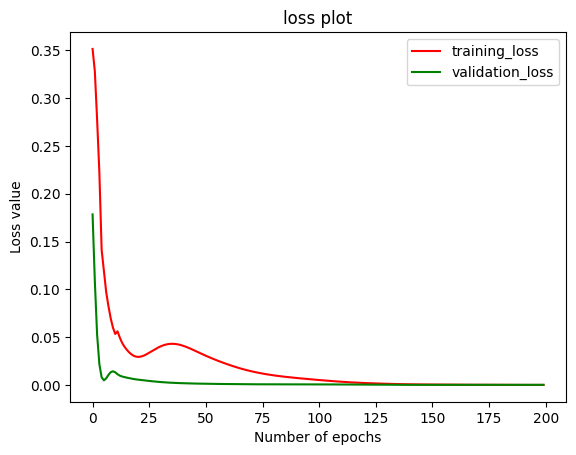

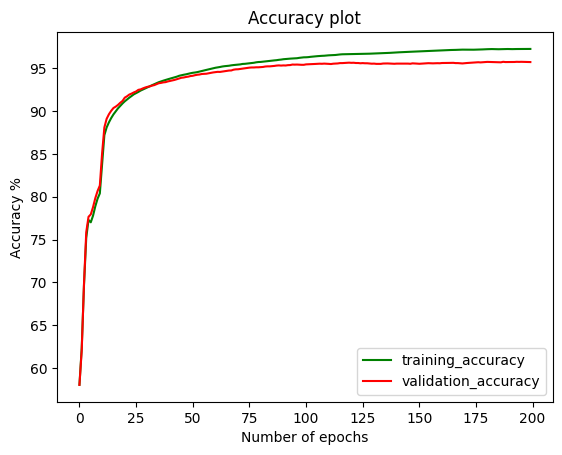

In [ ]:
dnn3 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=200, l_rate=0.01)
dnn3.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

In [ ]:
#Reason
1.Low Learning Rate (l_rate=0.01%)The small learning rate is the primary reason for the smoothness and stability of both curves. which prevents the oscillations seen with higher learning rates.
This allows the model to find a good minimum in the loss function without overshooting, leading to stable and consistent improvement across epochs.
2.Low, Controlled Overfitting: The model is generalizing very well from the training data to the validation data. This suggests that the combination of the network size ([784, 128, 64, 10])
and the low learning rate provides a good balance, effectively acting as a mild regularization.
3.Sufficient Epochs (epochs=200)The high number of epochs ensures the model reached full convergence.
The initial rapid improvement stops around epoch 50,
after which the curves continue to rise very slowly until they become almost flat around epoch 100.
4.Optimal Architecture-Parameter MatchThe smooth, high performance confirms that the chosen architecture (128, 64 hidden neurons) is appropriate for the complexity of the task (MNIST-like classification).


Epoch: 1, Time Spent: 37.21s, Accuracy: 79.61%
Epoch: 1, Time Spent: 37.21s, Accuracy: 80.53%
Epoch: 1, Time Spent: 37.21s, loss: 0.14
Epoch: 1, Time Spent: 37.21s, loss: 0.01
-------------------------------------------------------------
Epoch: 2, Time Spent: 73.58s, Accuracy: 87.72%
Epoch: 2, Time Spent: 73.59s, Accuracy: 88.38%
Epoch: 2, Time Spent: 73.59s, loss: 0.09
Epoch: 2, Time Spent: 73.59s, loss: 0.00
-------------------------------------------------------------
Epoch: 3, Time Spent: 110.21s, Accuracy: 89.97%
Epoch: 3, Time Spent: 110.21s, Accuracy: 90.39%
Epoch: 3, Time Spent: 110.21s, loss: 0.07
Epoch: 3, Time Spent: 110.21s, loss: 0.00
-------------------------------------------------------------
Epoch: 4, Time Spent: 146.84s, Accuracy: 91.19%
Epoch: 4, Time Spent: 146.84s, Accuracy: 91.44%
Epoch: 4, Time Spent: 146.84s, loss: 0.05
Epoch: 4, Time Spent: 146.84s, loss: 0.00
-------------------------------------------------------------
Epoch: 5, Time Spent: 182.87s, Accuracy:

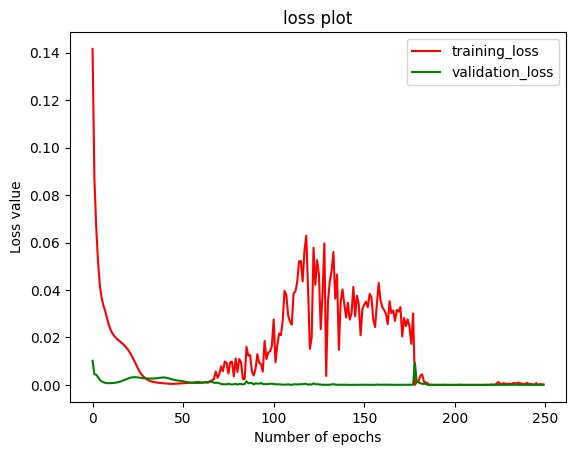

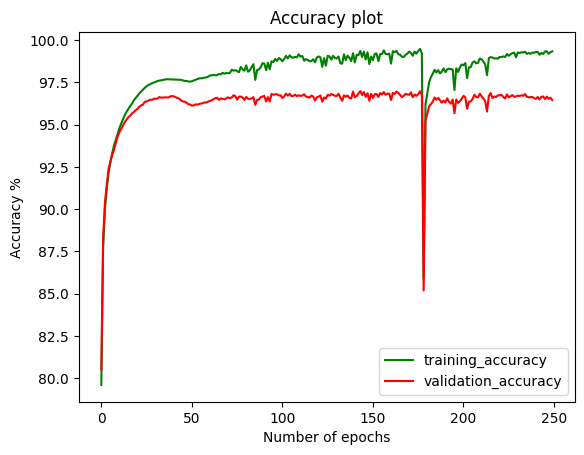

In [ ]:
dnn4 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=250, l_rate=0.05)
dnn4.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

In [ ]:
#Reason
1.Moderate Overfitting: A consistent gap of about 1-1.5% exists between the training (green) and validation (red) accuracy.
  The accuracy keeps slowly creeping up until epoch 180, indicating the model is still finding slightly better minima in the loss function.
2.Catastrophic Drop in Accuracy (approx Epoch 180): The most prominent feature is the simultaneous, sudden, massive drop in both training and validation accuracy from their high 90s to $\approx 85\%$ and $\approx 80\%$ respectively. This is a strong indicator of an external, uncontrolled event.
 The drop  suggests a sudden corruption of the model's state—possibly due to a change in the data batch a numerical instability .
3.Successful Recovery and Re-stabilization: After the drop, the model recovers quickly and returns to a similar performance level within approx 20 epochs.
Because the training process continued, the model's robustness (by the l_rate=0.05) allowed it to relearn the patterns and climb back to high accuracy,
stabilizing again around 99% (training) and 96.8% (validation) by the end.